## Train with early stopping

After training for 100 epochs, we found that the model converges at about 25 epochs.

To ensure consistency in time comparisons with the other models in our study, the following training with early stopping is in a separate notebook to be used on Google Colab.

In [4]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

# load data
df = pd.read_csv("preprocessed_reviews.csv")

# tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# replace out-of-vocab with 0
sequences = [[token if token < 3000 else 0 for token in seq] for seq in sequences]
X = pad_sequences(sequences, maxlen=300)
y = df['sentiment_binary'].values

extra_features = df[['review_length', 'exclamation_count']].values
scaler = StandardScaler()
extra_features_scaled = scaler.fit_transform(extra_features)

# train/test split
X_train_text, X_test_text, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    X, extra_features_scaled, y, test_size=0.2, random_state=42
)

# chosen hyperparameters
lr = 0.01
momentum = 0.9
lstm_units = 128
lstm_layers = 1
embedding_dim = 128
vocab_size = 10000

epochs = 100

print(f"\nTraining with lr={lr}, momentum={momentum}, lstm_units={lstm_units}, lstm_layers={lstm_layers}")
start_time = time.time()

# build model
text_input = Input(shape=(300,), name='text_input')
embedding = Embedding(vocab_size, embedding_dim)(text_input)
lstm = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)(embedding)

extra_input = Input(shape=(2,), name='extra_input')

combined = Concatenate()([lstm, extra_input])
dense = Dense(64, activation='relu')(combined)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[text_input, extra_input], outputs=output)
optimizer = SGD(learning_rate=lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    {'text_input': X_train_text, 'extra_input': X_train_extra},
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping]
)

# calculate time took to train model
elapsed = time.time() - start_time

if early_stopping.stopped_epoch > 0:
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience
    print(f"\nEarly stopping selected epoch {best_epoch + 1}")
else:
    print("\nTraining did not stop early.")



Training with lr=0.01, momentum=0.9, lstm_units=128, lstm_layers=1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 300, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    131,584 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 130)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ extra_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,384 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,420,033 (5.42 MB)

 Trainable params: 1,420,033 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 112s 931ms/step - accuracy: 0.5392 - loss: 0.6836 - val_accuracy: 0.5728 - val_loss: 0.6766
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 139s 904ms/step - accuracy: 0.5862 - loss: 0.6719 - val_accuracy: 0.5764 - val_loss: 0.6747
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 142s 903ms/step - accuracy: 0.5923 - loss: 0.6678 - val_accuracy: 0.5848 - val_loss: 0.6721
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 908ms/step - accuracy: 0.6038 - loss: 0.6645 - val_accuracy: 0.5909 - val_loss: 0.6703
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 915ms/step - accuracy: 0.6019 - loss: 0.6630 - val_accuracy: 0.5933 - val_loss: 0.6687
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 923ms/step - accuracy: 0.6139 - loss: 0.6537 - val_accuracy: 0.5993 - val_loss: 0.6650
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 141s 918ms/step - accuracy: 0.6041 - loss: 0.6600 - val_accuracy: 0.6089 - val_loss: 0.6607
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 108s 928ms/step - accuracy: 

## Plot loss and accuracy

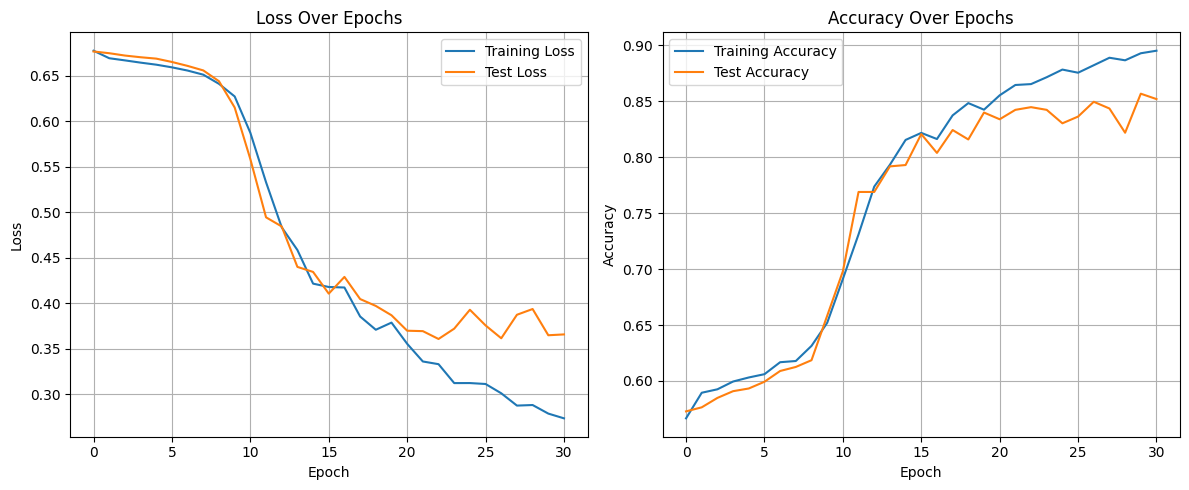

In [5]:
import matplotlib.pyplot as plt

# Plot val_loss and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot val_accuracy and accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Save metrics and model

In [6]:
import os
import json
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# get predictions
y_pred = model.predict({
    'text_input': X_test_text,
    'extra_input': X_test_extra
})
binary_predictions = (y_pred > 0.5).astype(int)
y_test_array = np.array(y_test)

# compute metrics
acc  = accuracy_score(y_test_array, binary_predictions)
prec = precision_score(y_test_array, binary_predictions)
rec  = recall_score(y_test_array, binary_predictions)
f1   = f1_score(y_test_array, binary_predictions)

clf_rep = classification_report(
    y_test_array, binary_predictions,
    target_names=["Negative", "Positive"],
    digits=4
)

# create evaluation directory if doesn't exist
os.makedirs("../evaluation", exist_ok=True)

# save numeric metrics as JSON
metrics = {
    "model": "lstm",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "time": elapsed
}
with open("../evaluation/lstm_metrics.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# create confusion matrix plot
cm = confusion_matrix(y_test_array, binary_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Neg","Pos"],
    yticklabels=["Neg","Pos"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.tight_layout()
plt.savefig("../evaluation/lstm_confusion_matrix.png")
plt.close()

print("evaluation metrics & plots saved to /evaluation/")

65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step
evaluation metrics & plots saved to /evaluation/
